# Project 6 - Sales analysis of a bookstore using Python

In [1]:
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.mlab as mlab
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import ks_2samp

C:\Users\floss\AppData\Local\Temp\ipykernel_9352\458526391.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Import 'Clients' document
clients = pd.read_csv('customers.csv', sep=';')

#Import the products document
produits = pd.read_csv('products.csv', sep=';')

#Import the product_id document
transactions = pd.read_csv('transactions.csv', sep=';')

### Exploration of the clients file

In [3]:
#Check dataframe's shape and head
print('clients = ', clients.shape)
clients.head()

clients =  (8621, 3)


client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [4]:
#Check data types
clients.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [5]:
#Check if the dataframe has missing values
print(clients.isnull().sum())

client_id    0
sex          0
birth        0
dtype: int64


In [6]:
#Search for duplicates for client_id
print(clients.loc[clients['client_id'].duplicated(keep=False),:])

Empty DataFrame
Columns: [client_id, sex, birth]
Index: []


In [7]:
#Check for outliers
clients.describe()

birth
count  8621.000000
mean   1978.275606
std      16.917958
min    1929.000000
25%    1966.000000
50%    1979.000000
75%    1992.000000
max    2004.000000

In [8]:
#Determine if client_id can be used as a primary key
print("Unique values for client_id = ", clients['client_id'].nunique())
print("Shape of the file = ", clients.shape)

Unique values for client_id =  8621
Shape of the file =  (8621, 3)


### Exploration of Products file

In [9]:
#Check dataframe's shape and head
print('produits =', produits.shape)
produits.head()

produits = (3286, 3)


id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [10]:
#Check data types
produits.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [11]:
#Check if the dataframe has missing values
print(produits.isnull().sum())

id_prod    0
price      0
categ      0
dtype: int64


In [12]:
#Check for duplicates for product ID
print(produits.loc[produits['id_prod'].duplicated(keep=False),:])

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []


In [13]:
#Search for outliers
produits.describe()

price        categ
count  3286.000000  3286.000000
mean     21.863597     0.370359
std      29.849786     0.615446
min       0.620000     0.000000
25%       6.990000     0.000000
50%      13.075000     0.000000
75%      22.990000     1.000000
max     300.000000     2.000000

In [14]:
#Determine if id_prod can be used as a primary key
print("Unique values for id_prod = ", produits['id_prod'].nunique())
print("Shape = ", produits.shape)

Unique values for id_prod =  3286
Shape =  (3286, 3)


### Exploration of transactions file

In [15]:
#Check dataframe's shape and head
print('Transactions =', transactions.shape)
transactions.head()

Transactions = (687534, 4)


id_prod                        date session_id client_id
0  0_1259  2021-03-01 00:01:07.843138        s_1     c_329
1  0_1390  2021-03-01 00:02:26.047414        s_2     c_664
2  0_1352  2021-03-01 00:02:38.311413        s_3     c_580
3  0_1458  2021-03-01 00:04:54.559692        s_4    c_7912
4  0_1358  2021-03-01 00:05:18.801198        s_5    c_2033

In [16]:
#Check data types
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

There are several rows for transactions where the date column contains times older than 24 hours (e.g. 2021-10-02 24:04:58.422464 present at position 198325). I decided to change only the date (first 10 characters) so that I could change the data type to datetime.

In [17]:
#Extract the date from the 'date' column
transactions['dateextract'] = transactions['date'].str[:10]
transactions.head()

id_prod                        date session_id client_id dateextract
0  0_1259  2021-03-01 00:01:07.843138        s_1     c_329  2021-03-01
1  0_1390  2021-03-01 00:02:26.047414        s_2     c_664  2021-03-01
2  0_1352  2021-03-01 00:02:38.311413        s_3     c_580  2021-03-01
3  0_1458  2021-03-01 00:04:54.559692        s_4    c_7912  2021-03-01
4  0_1358  2021-03-01 00:05:18.801198        s_5    c_2033  2021-03-01

In [18]:
#Delete the 'date' column and change the type of dateextract column to datetime
transactions = transactions.drop(columns='date')
transactions['dateextract'] = pd.to_datetime(transactions['dateextract'])
transactions.dtypes

id_prod                object
session_id             object
client_id              object
dateextract    datetime64[ns]
dtype: object

In [19]:
#Check if the dataframe has missing values
print(transactions.isnull().sum())

id_prod        0
session_id     0
client_id      0
dateextract    0
dtype: int64


# PART 1 – Analysis of sales indicators



### Revenue

In [20]:
# Find total revenue
ca = pd.merge(transactions, produits, on='id_prod', how='left')
ca_total = round(ca['price'].sum(), 2)
print('Total revenue =', ca_total)
print('---')

# Find total revenue for each year
print("Revenue for each year :")
ca['year'] = ca['dateextract'].dt.to_period('Y')
ca.groupby('year')['price'].sum().reset_index().rename(columns={'price':'ca'})

Total revenue = 12027663.1
---
Revenue for each year :


year          ca
0  2021  4944760.98
1  2022  6108681.81
2  2023   974220.31

####  Evolution of revenue over time (including calculation of a moving average)

In [21]:
#Create a grouping key that combines year and month. I converted it to a string, because plot does not allow datetime or period types.
ca['month_year'] = ca['dateextract'].dt.to_period('M')
ca['month_year'] = ca['month_year'].astype(str)

#Create a dataframe with revenue for each month, along with 2 month and 3 month moving averages
ca_par_mois = ca.groupby(['month_year'])['price'].sum().reset_index()

ca_par_mois['moving_average_3'] = ca_par_mois['price'].rolling(window=3).mean()
ca_par_mois['moving_average_2'] = ca_par_mois['price'].rolling(window=2).mean()

ca_par_mois

month_year      price  moving_average_3  moving_average_2
0     2021-03  482440.61               NaN               NaN
1     2021-04  476109.30               NaN        479274.955
2     2021-05  492943.47     483831.126667        484526.385
3     2021-06  484088.56     484380.443333        488516.015
4     2021-07  482835.40     486622.476667        483461.980
5     2021-08  482284.79     483069.583333        482560.095
6     2021-09  507240.68     490786.956667        494762.735
7     2021-10  494733.16     494752.876667        500986.920
8     2021-11  516167.73     506047.190000        505450.445
9     2021-12  525917.28     512272.723333        521042.505
10    2022-01  525338.99     522474.666667        525628.135
11    2022-02  535571.50     528942.590000        530455.245
12    2022-03  515456.53     525455.673333        525514.015
13    2022-04  492998.94     514675.656667        504227.735
14    2022-05  517132.60     508529.356667        505065.770
15    2022-06  496016.12     502049.220000        506574.360
16    2022-07  510783.12     507977.280000        503399.620
17    2022-08  506467.27     504422.170000        508625.195
18    2022-09  494114.53     503788.306667        500290.900
19    2022-10  507917.77     502833.190000        501016.150
20    2022-11  496664.94     499565.746667        502291.355
21    2022-12  510219.50     504934.070000        503442.220
22    2023-01  517540.55     508141.663333        513880.025
23    2023-02  456679.76     494813.270000        487110.155

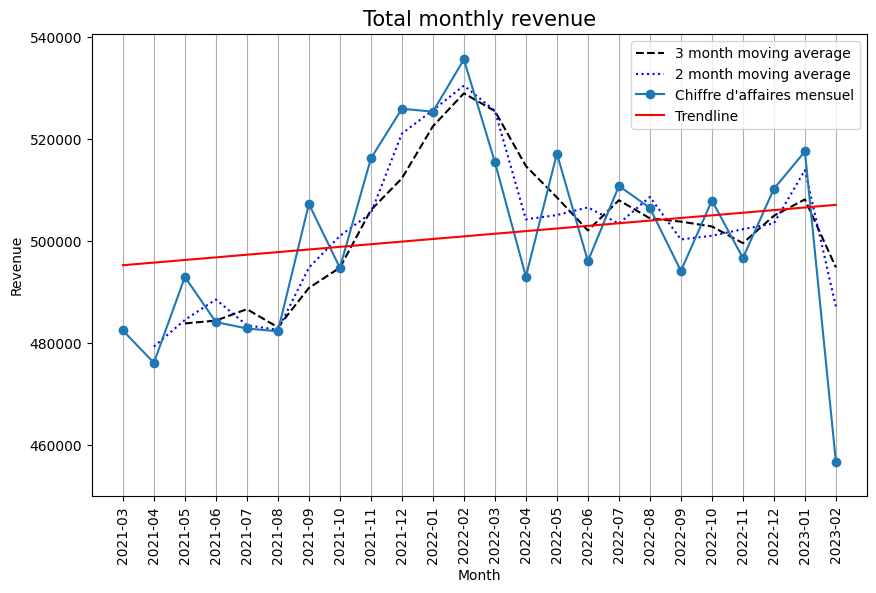

In [22]:
# Create a line plot with moving averages
plt.figure(figsize=(10, 6))
plt.plot(ca_par_mois['month_year'], ca_par_mois['moving_average_3'], linestyle='--', color='black', label='3 month moving average')
plt.plot(ca_par_mois['month_year'], ca_par_mois['moving_average_2'], linestyle='dotted', color='blue', label='2 month moving average')
plt.plot(ca_par_mois['month_year'], ca_par_mois['price'], marker='o', linestyle='-', label="Chiffre d'affaires mensuel")
plt.xlabel('Month')
plt.ylabel("Revenue")
plt.title("Total monthly revenue", size=15)
plt.xticks(rotation=90)
plt.grid(axis='x')

#Add a trendline
x = np.arange(len(ca_par_mois['month_year']))
slope, intercept = np.polyfit(np.arange(len(ca_par_mois['month_year'])), ca_par_mois['price'], 1)
trend_line = slope * x + intercept
plt.xlim(left=-1, right=len(ca_par_mois['month_year']))
plt.ylim(450000, max(ca_par_mois['price'])+5000) 
plt.plot(x, trend_line, color='red', label='Trendline')

plt.legend()

plt.show()

In [23]:
#Separate data into product categories
cat_0 = ca.loc[ca['categ']==0]
cat_1 = ca.loc[ca['categ']==1]
cat_2 = ca.loc[ca['categ']==2]

#Create dataframes showing the monthly revenue for each product category
cat_0_par_mois = cat_0.groupby(['month_year'])['price'].sum().reset_index()
cat_0_par_mois['moving_average'] = cat_0_par_mois['price'].rolling(window=3).mean()

cat_1_par_mois = cat_1.groupby(['month_year'])['price'].sum().reset_index()
cat_1_par_mois['moving_average'] = cat_1_par_mois['price'].rolling(window=3).mean()

cat_2_par_mois = cat_2.groupby(['month_year'])['price'].sum().reset_index()
cat_2_par_mois['moving_average'] = cat_2_par_mois['price'].rolling(window=3).mean()

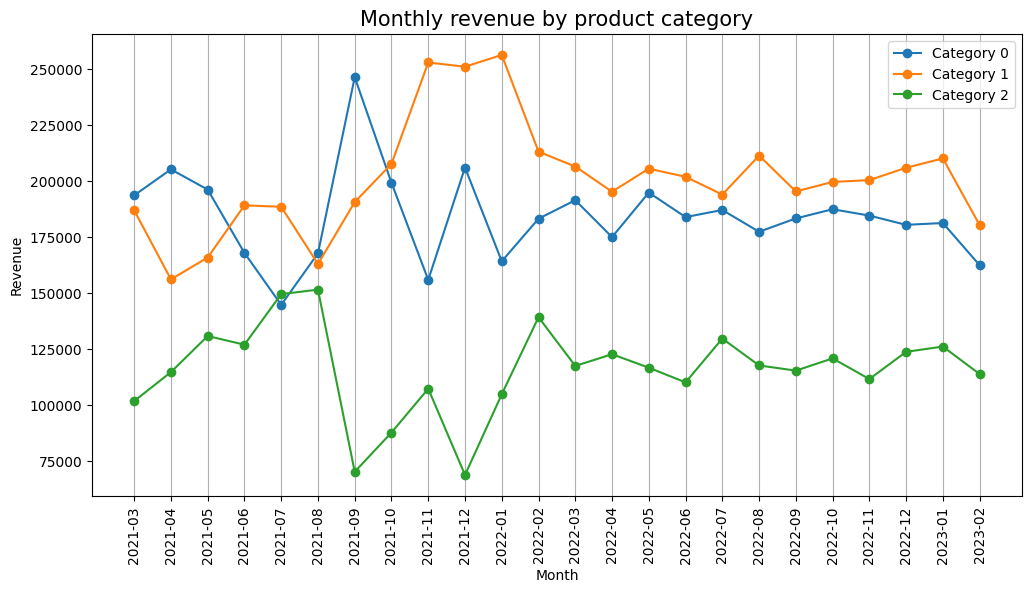

In [24]:
#Create a line graph with monthly revenue for each product category
plt.figure(figsize=(12, 6))
plt.plot(cat_0_par_mois['month_year'], cat_0_par_mois['price'], marker='o', linestyle='-', label="Category 0")
plt.plot(cat_1_par_mois['month_year'], cat_1_par_mois['price'], marker='o', linestyle='-', label="Category 1")
plt.plot(cat_2_par_mois['month_year'], cat_2_par_mois['price'], marker='o', linestyle='-', label="Category 2")
plt.xlabel('Month')
plt.ylabel("Revenue")
plt.title("Monthly revenue by product category", size=15)
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.legend()
plt.show()

In [25]:
#Merge product and transaction dataframes
produits_transactions = pd.merge(transactions, produits, on='id_prod', how='left')
produits_transactions.head()

id_prod session_id client_id dateextract  price  categ
0  0_1259        s_1     c_329  2021-03-01  11.99      0
1  0_1390        s_2     c_664  2021-03-01  19.37      0
2  0_1352        s_3     c_580  2021-03-01   4.50      0
3  0_1458        s_4    c_7912  2021-03-01   6.55      0
4  0_1358        s_5    c_2033  2021-03-01  16.49      0

Text(0.5, 1.0, 'Percentage of total revenue')

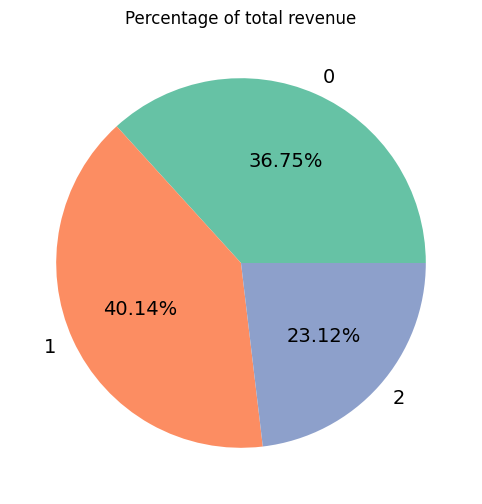

In [26]:
# Determine total revenue for each product category
ca_categ = produits_transactions.groupby(['categ'])['price'].sum().reset_index()
ca_categ = ca_categ.rename(columns ={'price':'chiffre_daffaires'})

#Create a pieplot showing how much each category contributes to total revenue 
plt.figure(figsize=(8, 6))
plt.pie(x= ca_categ['chiffre_daffaires'], labels = ca_categ['categ'], autopct='%.2f%%', textprops={'fontsize': 14}, colors=sns.color_palette('Set2'))
plt.title("Percentage of total revenue", size=12)

In [27]:
# Number of sales per category
produits_categ = produits_transactions.groupby(['categ'])['id_prod'].nunique().reset_index()

# Merge ca_categ and produits_categ
categ_ventes_ca = pd.merge(ca_categ, produits_categ, on='categ', how='inner')
categ_ventes_ca = categ_ventes_ca.rename(columns ={'id_prod':'nombre_produits'})

#Determine the average revenue for each product for each product category
categ_ventes_ca['ca_moyen_par_produit'] = categ_ventes_ca['chiffre_daffaires']/categ_ventes_ca['nombre_produits']

categ_ventes_ca

categ  chiffre_daffaires  nombre_produits  ca_moyen_par_produit
0      0         4419730.97             2292           1928.329394
1      1         4827657.11              737           6550.416703
2      2         2780275.02              236          11780.826356

It is interesting to note that even though there are only 236 products in category 2 (compared to 2292 in category zero and 737 in category 1), this still represents 23.12 percent of our turnover.

Additionally, it is interesting to note that although Category 2 has the lowest revenue, it also has the highest average revenue per product. It is worth checking the average price for each category and whether there are any price outliers.

### Zoom in on the references, to see the tops and flops, the distribution by category, etc.

In [28]:
#Create a dataframe with the number of products sold for each product id
produits_vendus = produits_transactions.groupby(['categ','id_prod'])['session_id'].count().reset_index()
produits_vendus = produits_vendus.rename(columns={'session_id':'produits_vendus'})
produits_vendus = produits_vendus.sort_values('produits_vendus', ascending=False)

Text(0.5, 1.0, 'Percentage of total sales')

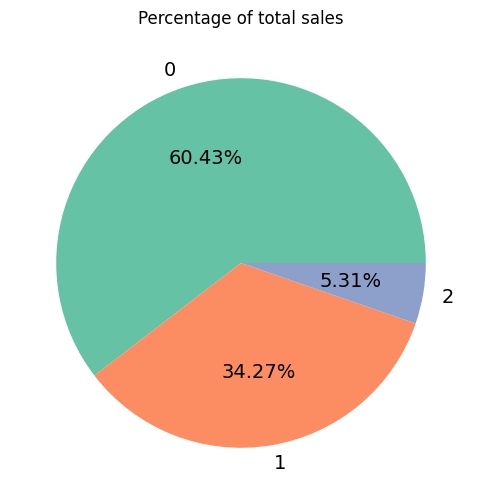

In [29]:
# Determine the number of sales for each category
produits_compte = produits_vendus.groupby('categ')['produits_vendus'].sum().reset_index()

#Create a pieplot showing the percentage of total sales for each category
plt.figure(figsize=(8, 6))
plt.pie(x= produits_compte['produits_vendus'], labels = produits_compte['categ'], autopct='%.2f%%', textprops={'fontsize': 14}, colors=sns.color_palette('Set2'))
plt.title("Percentage of total sales", size=12)

In [30]:
# Determine the number of sales per product
produits_vendus_categ = produits_vendus.groupby('categ')['id_prod'].count().reset_index().rename(columns={'id_prod':'nombre_de_produits'})
produits_vendus_nombre = pd.merge(produits_compte, produits_vendus_categ, on='categ', how='inner')

# Find the average number of sales for each product for each category
produits_vendus_nombre['moyen_ventes_par_produit'] = produits_vendus_nombre['produits_vendus']/produits_vendus_nombre['nombre_de_produits']
produits_vendus_nombre

categ  produits_vendus  nombre_de_produits  moyen_ventes_par_produit
0      0           415459                2292                181.264834
1      1           235592                 737                319.663501
2      2            36483                 236                154.588983

#### The most popular products

Category 1 has most of the products that have only been sold one time. Category 2 doesn't have any products with only one sale. 

In [31]:
#Calculate best and worst sellers
produits_vendus_sorted = produits_vendus.sort_values('produits_vendus', ascending=False)
top_10_ventes = produits_vendus_sorted.head(10)
pire_10_ventes = produits_vendus_sorted.tail(10)

#Sort product sales for each category
ventes_sorted_0 = produits_vendus_sorted.loc[produits_vendus_sorted['categ']==0]
ventes_sorted_1 = produits_vendus_sorted.loc[produits_vendus_sorted['categ']==1]
ventes_sorted_2 = produits_vendus_sorted.loc[produits_vendus_sorted['categ']==2]

#Identify best sellers for each category
ventes_top_10_0 = ventes_sorted_0.head(10)
ventes_top_10_1 = ventes_sorted_1.head(10)
ventes_top_10_2 = ventes_sorted_2.head(10)


In [32]:
#Create a function to create a barplot 
def crée_graphique(dataframe, title):
    plt.figure(figsize=(25, 3))
    graph = sns.barplot(data=dataframe, x='id_prod', y='produits_vendus', errorbar=None, estimator=sum)
    plt.title(title, size=20)
    plt.xlabel("Product ID", size=18)
    plt.xticks(fontsize=15)
    plt.ylabel("Total sales", size=18)
    plt.yticks(fontsize=15)
    plt.ylim([0, 3000])
    sns.set_palette(palette='Set2')
    

    for i in graph.containers:
        graph.bar_label(i, fontsize=15)

    plt.show()

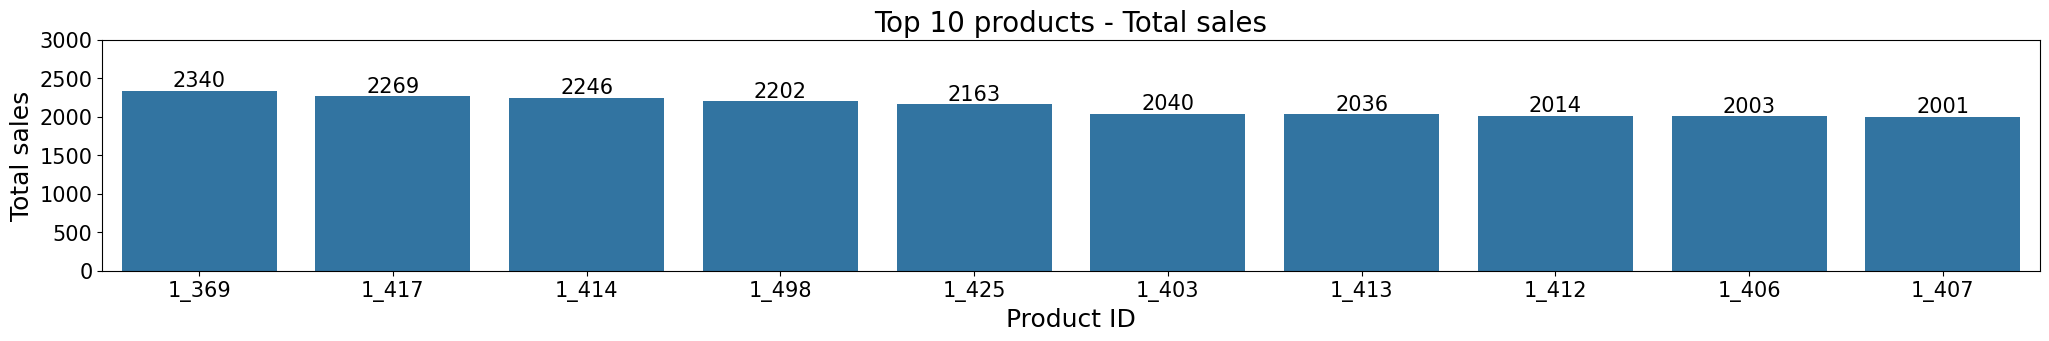

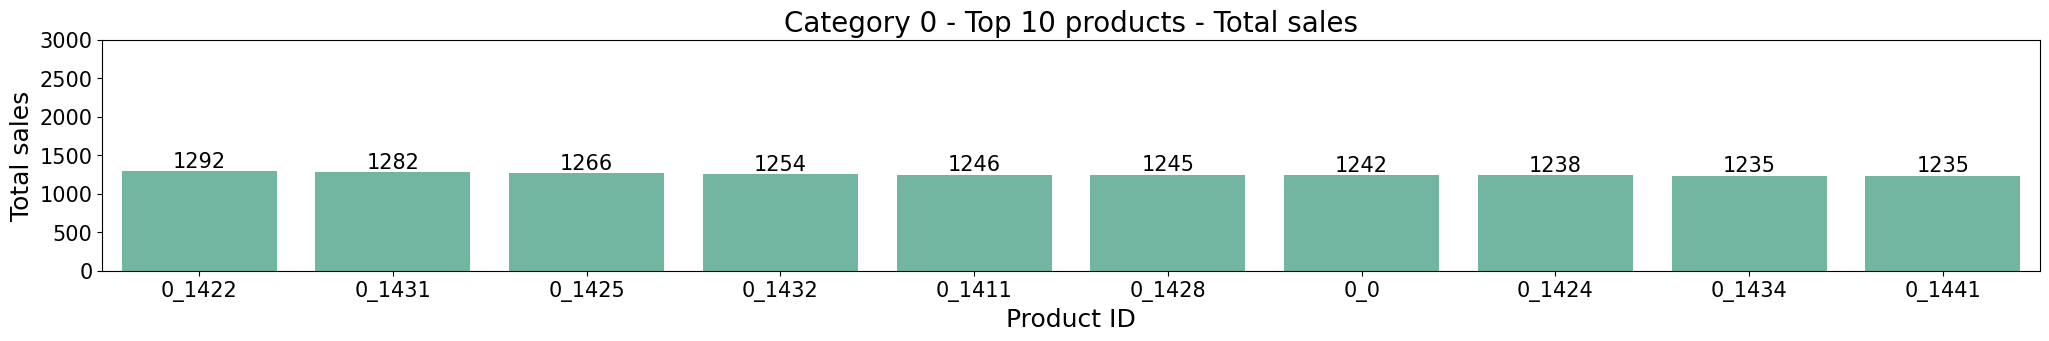

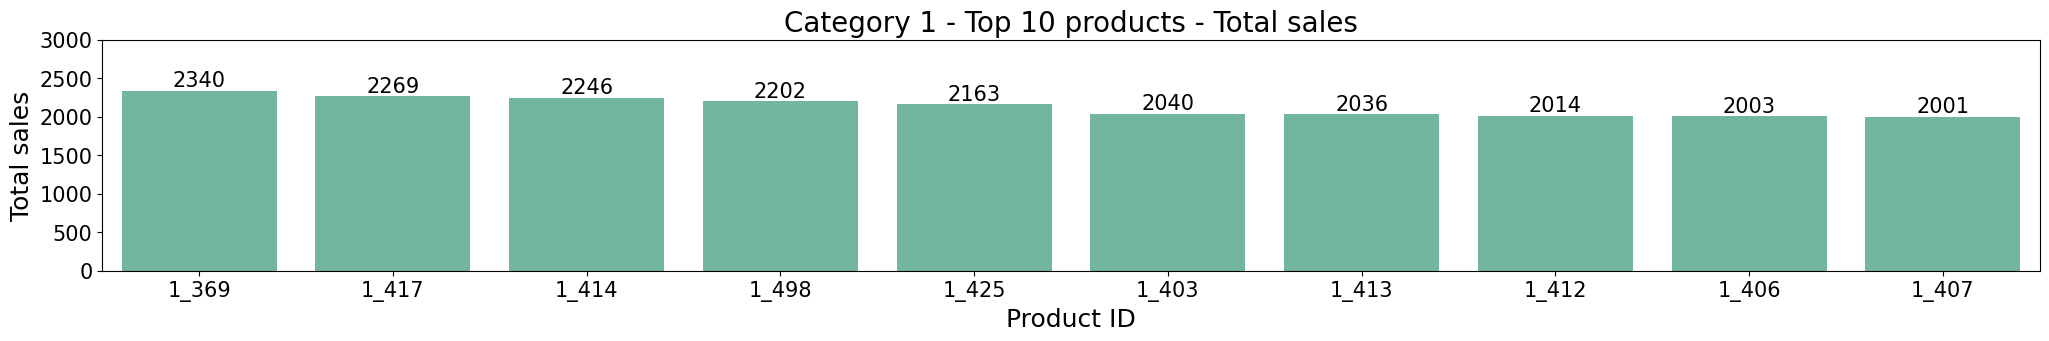

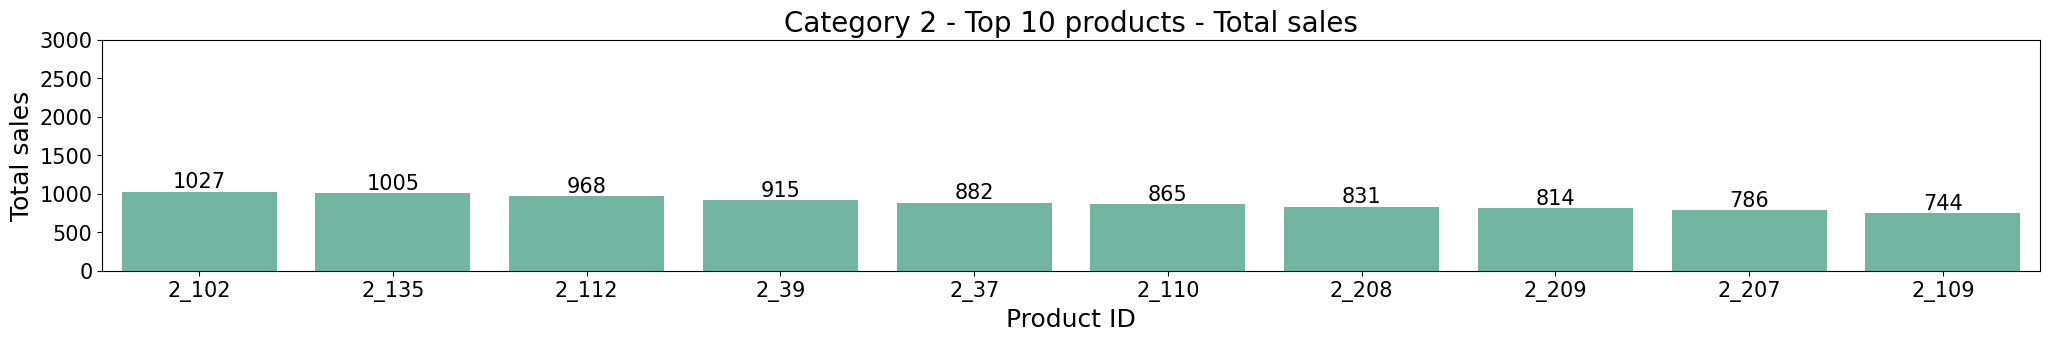

In [33]:
#Graph showing top 10 highest selling products overall
crée_graphique(top_10_ventes, "Top 10 products - Total sales")

#Category 0 - Graph of top 10 highest and lowest selling products
crée_graphique(ventes_top_10_0, "Category 0 - Top 10 products - Total sales")

#Category 1 - Graph of top 10 highest and lowest selling products
crée_graphique(ventes_top_10_1, "Category 1 - Top 10 products - Total sales")

#Category 2 - Graph of top 10 highest and lowest selling products
crée_graphique(ventes_top_10_2, "Category 2 - Top 10 products - Total sales")

In [34]:
sorted_ventes_produits = transactions.groupby('id_prod')['client_id'].count().reset_index().sort_values('client_id', ascending=False).rename(columns={'client_id':'nombre_ventes'})
print("The average number of sales for each product is ", round(sorted_ventes_produits['nombre_ventes'].mean(),0),"- however, the 10 products with highest sales have sales of around 10 times this.")

The average number of sales for each product is  211.0 - however, the 10 products with highest sales have sales of around 10 times this.


#### The least popular products (by sales numbers)

In [35]:
#Find the number of products sold only once
une_vente = (produits_vendus.loc[produits_vendus['produits_vendus']==1])
nombre_une_vente = une_vente['produits_vendus'].count()
categ_0_une_vente = (produits_vendus['produits_vendus'].loc[(produits_vendus['produits_vendus']==1) & (produits_vendus['categ']==0)]).count()
categ_1_une_vente = (produits_vendus['produits_vendus'].loc[(produits_vendus['produits_vendus']==1) & (produits_vendus['categ']==1)]).count()
categ_2_une_vente = (produits_vendus['produits_vendus'].loc[(produits_vendus['produits_vendus']==1) & (produits_vendus['categ']==2)]).count()


print("There are", nombre_une_vente, "products that have only been sold once.")
print('---')
print(categ_0_une_vente, "products from category 0 have only been sold once")
print(categ_1_une_vente, "products from category 1 have only been sold once")
print(categ_2_une_vente, "products from category 2 have only been sold once")

There are 18 products that have only been sold once.
---
15 products from category 0 have only been sold once
0 products from category 1 have only been sold once
3 products from category 2 have only been sold once


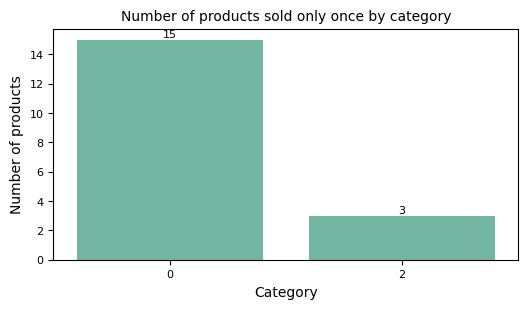

In [36]:
#Create a barplot that shows the number of products sold only once by category
une_vente_categ = une_vente.groupby('categ')['produits_vendus'].sum().reset_index()

plt.figure(figsize=(6, 3))
graph = sns.barplot(data=une_vente_categ, x='categ', y='produits_vendus', errorbar=None, estimator=sum)
plt.title("Number of products sold only once by category", size=10)
plt.xlabel("Category", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Number of products", size=10)
plt.yticks(fontsize=8)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

#### Products with the highest and the lowest revenue

In [37]:
#Create the dataframes that show the products with the largest and smallest turnover
ca_categories_sorted = produits_transactions.groupby(['id_prod', 'categ'])['price'].sum().reset_index()
ca_categories_sorted = ca_categories_sorted.sort_values('price', ascending=False)
top_10 = ca_categories_sorted.head(10)
pire_10 = ca_categories_sorted.tail(10)

In [38]:
#Create a function to create a barplot
def crée_graphique(dataframe, title):
    plt.figure(figsize=(25, 12))
    graph = sns.barplot(data=dataframe, x='id_prod', y='price', errorbar=None, estimator=sum)
    plt.title(title, size=33)
    plt.xlabel("Product ID", size=30)
    plt.xticks(fontsize=23)
    plt.ylabel("Revenue", size=30)
    plt.yticks(fontsize=23)
    sns.set_palette(palette='Set2')

    for i in graph.containers:
        graph.bar_label(i, fontsize=20)

    plt.show()

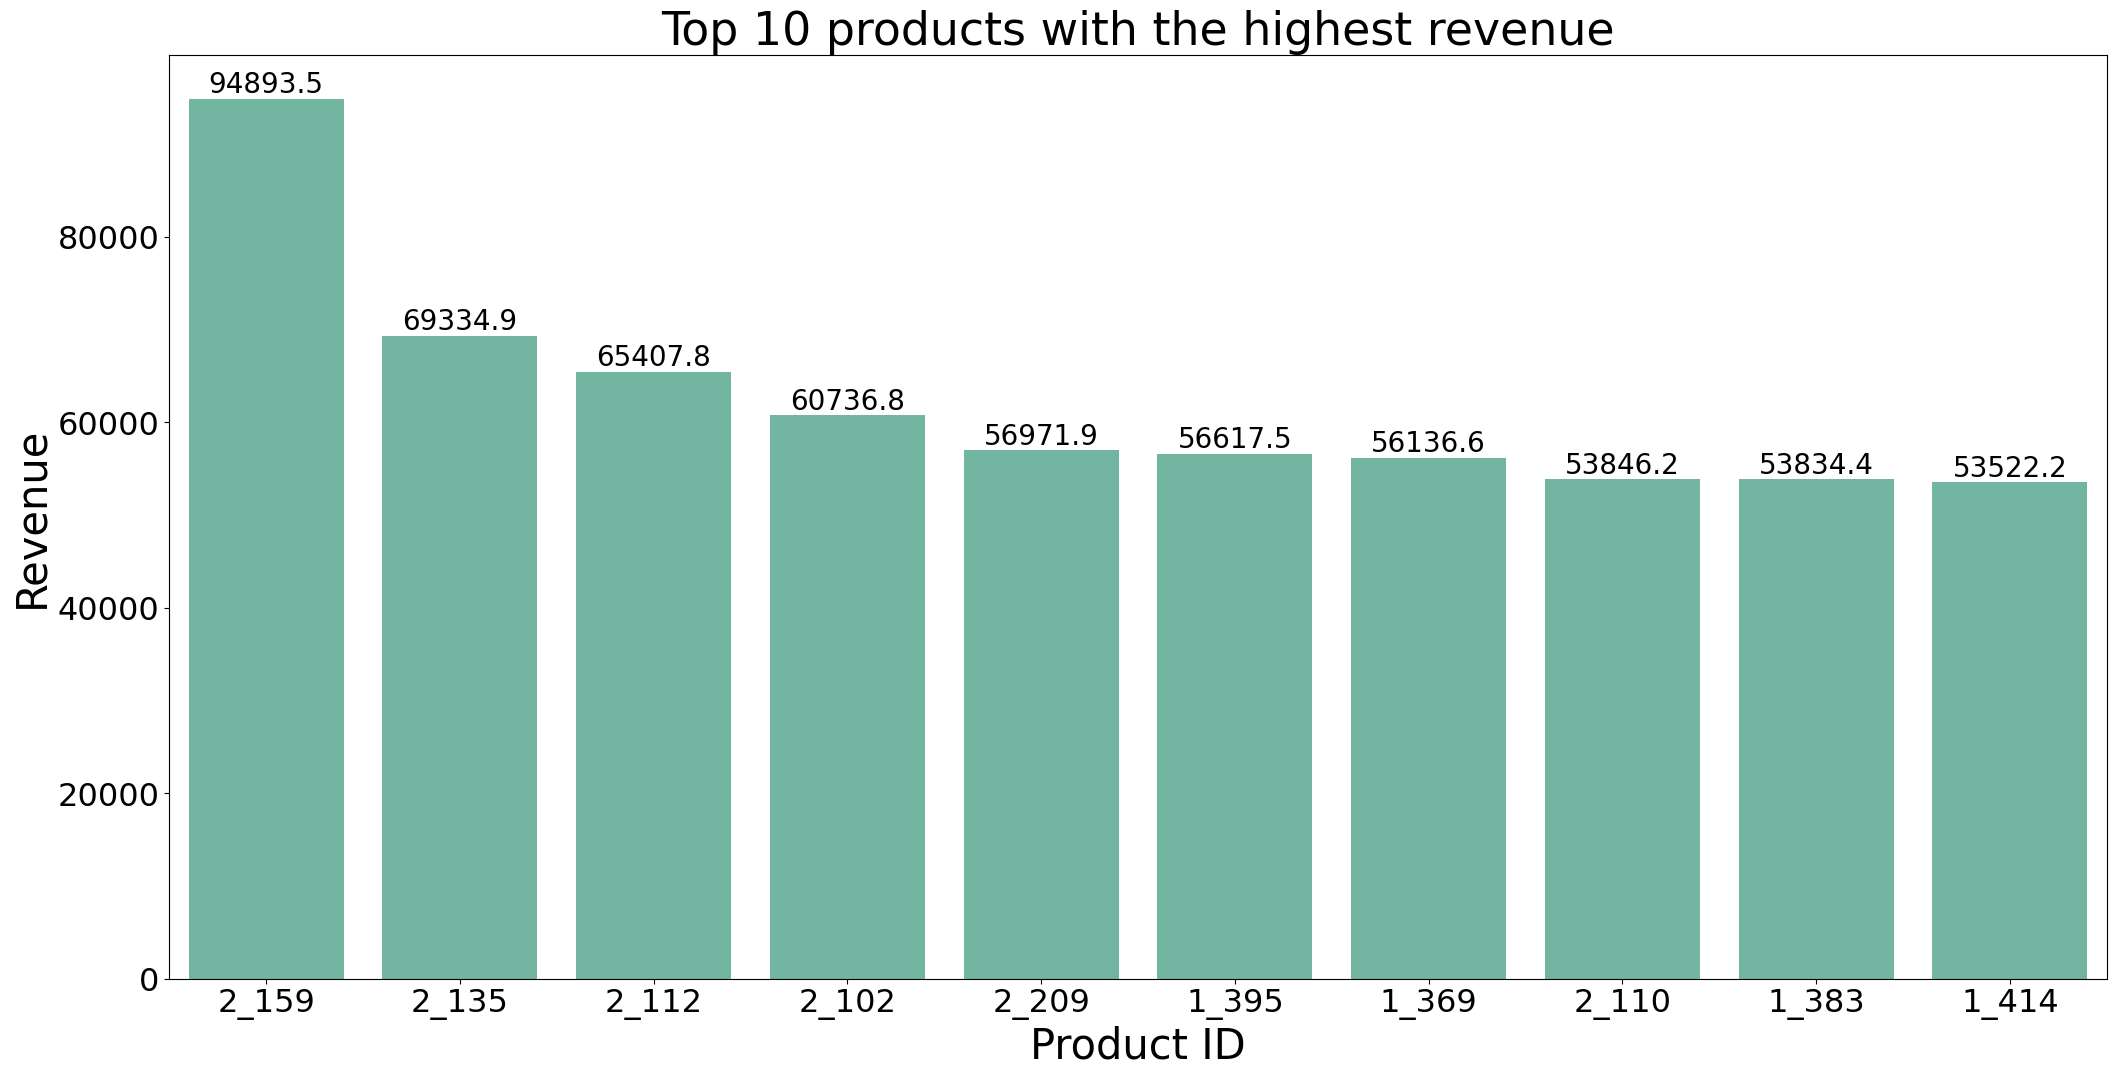

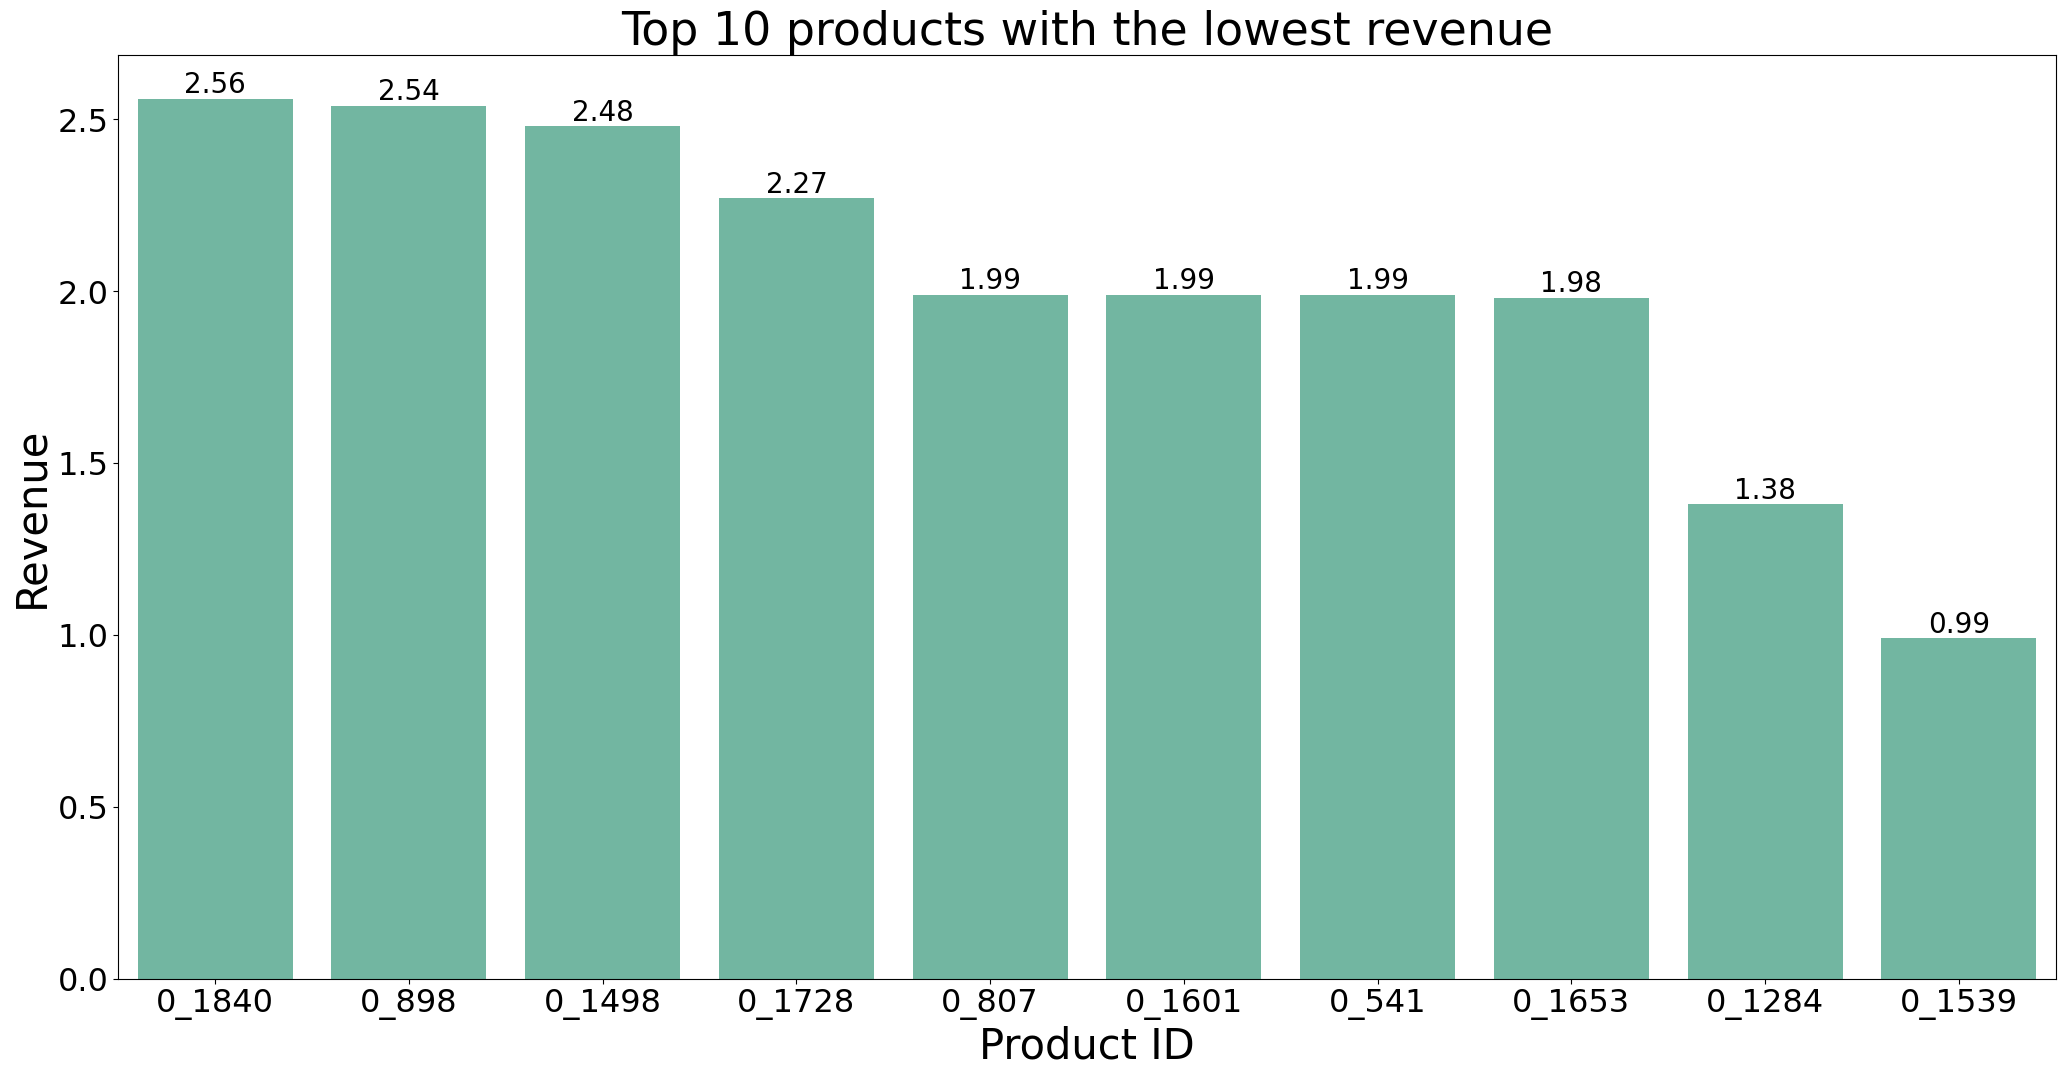

In [39]:
#Graphs showing the 10 products with the highest revnue and the 10 products with the lowest revenue
crée_graphique(top_10, "Top 10 products with the highest revenue")
crée_graphique(pire_10, "Top 10 products with the lowest revenue")


6 of the products with the highest turnovers are from category 2. 4 come from category 1, and nothing comes from category 0. On the other hand, the 10 products with the lowest turnovers all come from category 0.

### Some information on the profiles of our customers and the distribution of turnover between them

#### Client profiles

In [40]:
# Show how many clients are women and how many are men 
print('Number of male clients =', clients.loc[clients['sex']=='m','client_id'].count())
print('Number of female clients =', clients.loc[clients['sex']=='f','client_id'].count())

Number of male clients = 4131
Number of female clients = 4490


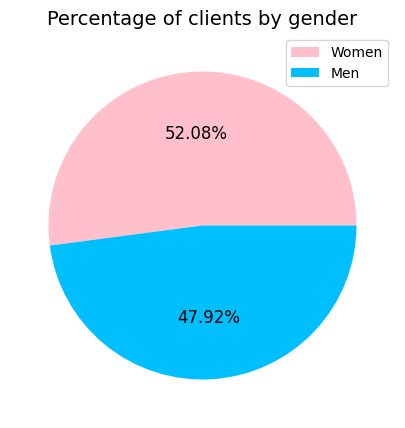

In [41]:
# Pieplot showing percentage of clients by sex
count_clients = clients.groupby('sex')['client_id'].nunique().reset_index()

plt.figure(figsize=(6, 5))
plt.pie(x= count_clients['client_id'], autopct='%.2f%%', textprops={'fontsize': 12}, colors=['pink', 'deepskyblue'])
plt.title("Percentage of clients by gender", size=14)
plt.legend(labels = ['Women', 'Men'])

We have 4490 female clients and 4131 male clients. This is a difference of 4.16 percent.

In [42]:
#Create an 'age' column
clients['age'] = 2023 - clients['birth']

#Check the averages for age data
print('Mean age =', clients['age'].mean())
print('Median age =', clients['age'].median())
print('Mode age =', clients['age'].mode())
print('-----------')

#Check quartiles
display(clients.describe())

Mean age = 44.724393921818816
Median age = 44.0
Mode age = 0    19
Name: age, dtype: int64
-----------


birth          age
count  8621.000000  8621.000000
mean   1978.275606    44.724394
std      16.917958    16.917958
min    1929.000000    19.000000
25%    1966.000000    31.000000
50%    1979.000000    44.000000
75%    1992.000000    57.000000
max    2004.000000    94.000000

It will be easier to look at age data if I group birth years together. This will also make it easier for me to identify trends.

In [43]:
#Create age groups
age_bins = [18, 23, 27, 31, 35, 39, 43, 47 ,51, 55, 59 ,63, 67, 71, 75, 79, 83, 87, 91, 95]
age_labels = ['19-23', '24-27','28-31','32-35','36-39','40-43','44-47','48-51','52-55','56-59','60-63','64-67','68-71','72-75','76-79','80-83','84-87',
                   '88-91','92-95',]
clients['groupe_dage'] = pd.cut(clients['age'], bins=age_bins, labels=age_labels)

#Create dataframe with clients sorted by age group
clients_age_genre = clients.groupby(['groupe_dage', 'sex'])['client_id'].nunique().reset_index()

C:\Users\floss\AppData\Local\Temp\ipykernel_9352\1353643854.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clients_age_genre = clients.groupby(['groupe_dage', 'sex'])['client_id'].nunique().reset_index()


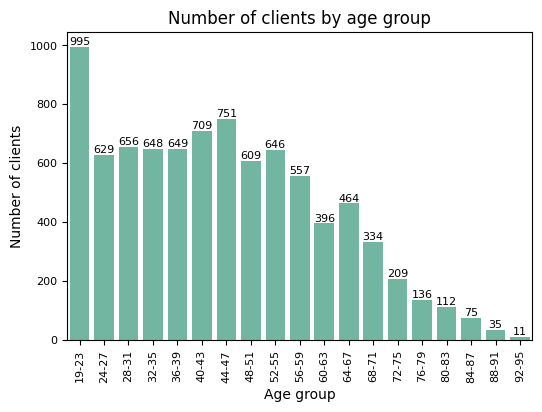

In [44]:
# Create a graph showing the number of clients we have by their age group
plt.figure(figsize=(6, 4))
graph = sns.barplot(data=clients_age_genre, x='groupe_dage', y='client_id', errorbar=None, estimator=sum)
plt.title("Number of clients by age group", size=12)
plt.xlabel("Age group", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Number of clients", size=10)
plt.yticks(fontsize=8)
plt.xticks(rotation=90)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

It is perhaps not surprising that our company has very few customers born before 1949. While people aged 75 and over represent 10% of the French population (https://www.statista.com/statistics/464032/distribution-population-age-group-france/), they are less likely to have computer skills.

The age group that makes the most purchases (995) is 19-23 year olds. This age group is very computer literate and is likely very comfortable with online shopping.

C:\Users\floss\AppData\Local\Temp\ipykernel_9352\399029965.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  clients_age_pyramide = clients_age_genre.pivot_table(index='groupe_dage', columns='sex', values='client_id', aggfunc='sum').reset_index()


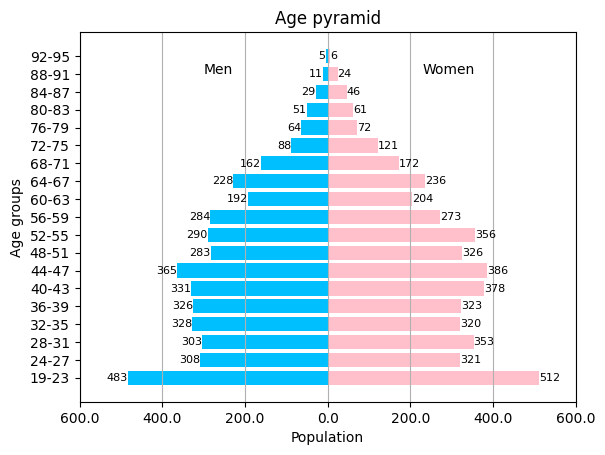

In [45]:
#Create an age pyramid

clients_age_pyramide = clients_age_genre.pivot_table(index='groupe_dage', columns='sex', values='client_id', aggfunc='sum').reset_index()

fig, ax = plt.subplots()

ax.barh(clients_age_pyramide['groupe_dage'], -clients_age_pyramide['m'], color='deepskyblue')
ax.barh(clients_age_pyramide['groupe_dage'], clients_age_pyramide['f'], color='pink')

ax.set_xlabel('Population')
ax.set_ylabel("Age groups")
ax.set_title('Age pyramid')

ax.set_xticks(ax.get_xticks()[::1])
ax.set_xticklabels([abs(tick) for tick in ax.get_xticks()[::1]])

for i, (m, f, groupe_dage) in enumerate(zip(clients_age_pyramide['m'], clients_age_pyramide['f'], clients_age_pyramide['groupe_dage'])):
    ax.text(-m, i, f"{abs(m)}", ha='right', va='center', fontsize=8)
    ax.text(f, i, f"{abs(f)}", ha='left', va='center', fontsize=8)

plt.text(-300, 17, "Men", fontsize=10)
plt.text(230, 17, "Women", fontsize=10)
plt.grid(axis='x')

plt.show()


16 out of the 19 age groups have more women than men. But, for the most part, the difference in gender representation isn't that big.

### Lorenz curve

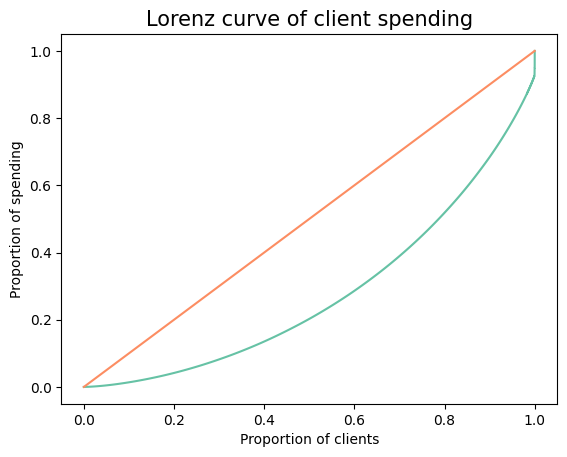

Gini index =  0.44189587995615665


In [46]:
#Create a Lorenz curve - all customers
clients_dépenses = ca.groupby('client_id')['price'].sum().reset_index().rename(columns={'price':'dépenses'})
clients_dép = clients_dépenses['dépenses'].values
n = len(clients_dép)
lorenz = np.cumsum(np.sort(clients_dép)) / clients_dép.sum()
lorenz = np.append([0],lorenz) 

plt.title("Lorenz curve of client spending", size=15)
plt.xlabel("Proportion of clients", size=10)
plt.ylabel("Proportion of spending", size=10)
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1])
plt.show()


#Identify the Gini Index
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
S = 0.5 - AUC
gini = 2*S
print("Gini index = ", gini) 

A Gini index of 0.44 suggests that customer spending is unevenly distributed.

The Lorenz curve shows that our top 20 percent of customers account for about 50 percent of our revenue. Furthermore, the poorest 50 percent of customers only represent around 20 percent of our total turnover.

### Top Clients

In [47]:
#Find top 5% of customers and top 10 customers by spending
clients_dépenses_sort = clients_dépenses.sort_values('dépenses', ascending=False)
top_clients_5 = clients_dépenses_sort.head(430)
top_10_CA = top_clients_5.head(10)
top_10_CA

client_id   dépenses
677     c_1609  326039.89
4388    c_4958  290227.03
6337    c_6714  153918.60
2724    c_3454  114110.57
634     c_1570    5285.82
2513    c_3263    5276.87
1268    c_2140    5260.18
2108    c_2899    5214.05
7006    c_7319    5155.77
7715    c_7959    5135.75

In [48]:
print("Revenue from top 5% of clients  = €", top_clients_5['dépenses'].sum())
print('---')
print("The 5% of clients who spend the most (430 clients) contribute to ", round((top_clients_5['dépenses'].sum()/clients_dépenses['dépenses'].sum())*100,2), "% of our total revenue")
print('---')
print("The 5% of clients who spend the most have spent an average of ", round(top_clients_5['dépenses'].mean(),2), "€ with us. However, the overall average turnover per person is only €", round(clients_dépenses['dépenses'].mean(),2))

Revenue from top 5% of clients  = € 2529402.05
---
The 5% of clients who spend the most (430 clients) contribute to  21.03 % of our total revenue
---
The 5% of clients who spend the most have spent an average of  5882.33 € with us. However, the overall average turnover per person is only € 1398.57


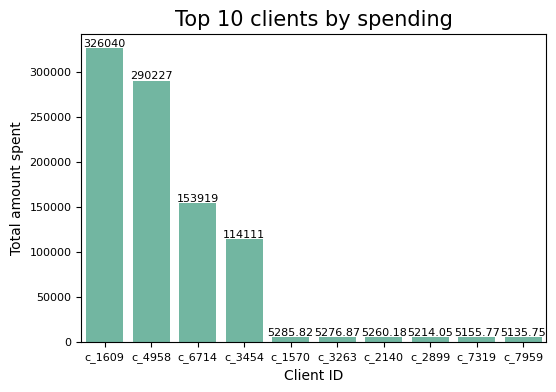

In [49]:
# Graph of the top 10 clients by spending
plt.figure(figsize=(6, 4))
graph = sns.barplot(data=top_10_CA, x='client_id', y='dépenses', errorbar=None, estimator=sum)
plt.title("Top 10 clients by spending", size=15)
plt.xlabel("Client ID", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Total amount spent", size=10)
plt.yticks(fontsize=8)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

There are 4 customers who spent significantly more than the other customers (more than 100,000 euros). These are probably professional customers who buy books in bulk.

### Top 10 customers by purchasing frequency

In [50]:
#Find top 10 clients by purchasing frequency
clients_achats = transactions.groupby('client_id')['session_id'].count().reset_index().sort_values('session_id', ascending=False).rename(columns={'session_id':'nombre_dachats'})
top_10_achats = clients_achats.head(10)

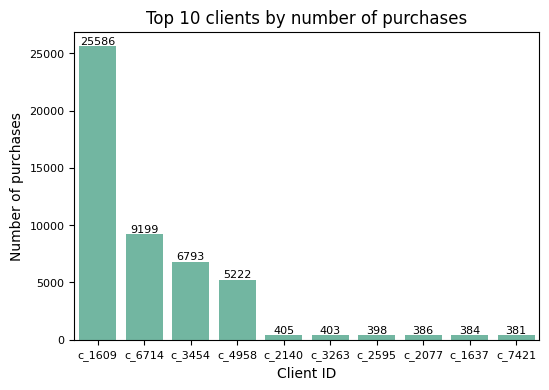

In [88]:
# Graph of the top 10 clients by purchase frequency
plt.figure(figsize=(6, 4))
graph = sns.barplot(data=top_10_achats, x='client_id', y='nombre_dachats', errorbar=None, estimator=sum)
plt.title("Top 10 clients by number of purchases", size=12)
plt.xlabel("Client ID", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Number of purchases", size=10)
plt.yticks(fontsize=8)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

In [52]:
#Find the clients that are both top 10 spenders AND top 10 clients in terms of number of purchases.
pd.merge(top_10_achats, top_10_CA, on='client_id', how='inner')

client_id  nombre_dachats   dépenses
0    c_1609           25586  326039.89
1    c_6714            9199  153918.60
2    c_3454            6793  114110.57
3    c_4958            5222  290227.03
4    c_2140             405    5260.18
5    c_3263             403    5276.87

6 of our top 10 customers in terms of spending are also in the top 10 customers in terms of number of purchases made. These include our 4 big spenders, as well as customer IDs c_2140 and c_3263.

Customer 1609 spends the most of all our customers and also makes the most frequent purchases.

### Top 10 clients by category

In [53]:
#Create dataframe with number of purchases per category for each customer
prod_trans = pd.merge(produits, transactions, how='left', on='id_prod')
clients_categs = prod_trans.groupby(['client_id', 'categ'])['id_prod'].count().reset_index().rename(columns={'id_prod':'nombre_dachats'})

In [54]:
#Separate by category and find the top 10 customers
top_10_clients_categs_0 = clients_categs.loc[clients_categs['categ']==0].sort_values('nombre_dachats', ascending=False).head(10)
top_10_clients_categs_1 = clients_categs.loc[clients_categs['categ']==1].sort_values('nombre_dachats', ascending=False).head(10)
top_10_clients_categs_2 = clients_categs.loc[clients_categs['categ']==2].sort_values('nombre_dachats', ascending=False).head(10)



In [55]:
#Create a function to make graphs
def categ_client_graphique(dataframe, title):
    plt.figure(figsize=(5, 4))
    graph = sns.barplot(data=dataframe, x='client_id', y='nombre_dachats', errorbar=None, estimator=sum)
    plt.title(title, size=12)
    plt.xlabel("Client ID", size=11)
    plt.xticks(fontsize=10)
    plt.ylabel("Number of purchases", size=11)
    plt.yticks(fontsize=10)
    plt.xticks(rotation=90)
    sns.set_palette(palette='Set2')

    for i in graph.containers:
        graph.bar_label(i, fontsize=8)

    plt.show()

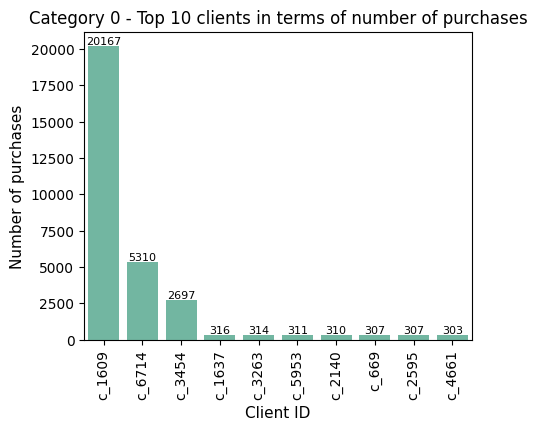

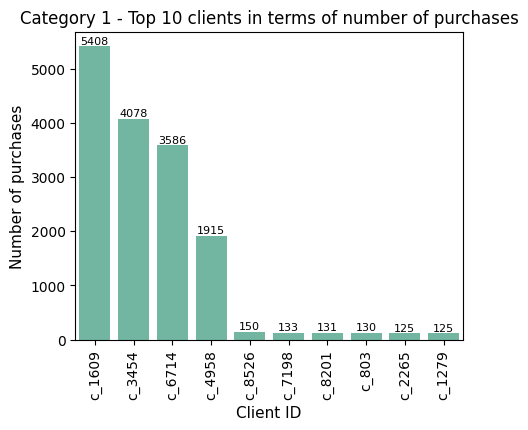

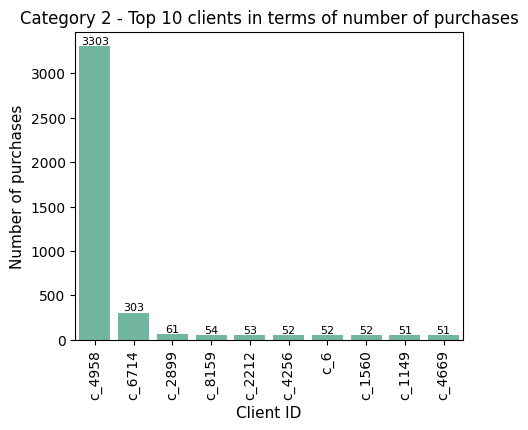

In [56]:
#Create graphs of top 10 clients for each category of product
categ_client_graphique(top_10_clients_categs_0, "Category 0 - Top 10 clients in terms of number of purchases")
categ_client_graphique(top_10_clients_categs_1, "Category 1 - Top 10 clients in terms of number of purchases")
categ_client_graphique(top_10_clients_categs_2, "Category 2 - Top 10 clients in terms of number of purchases")


In [57]:
#Check if there are clients that appear in all 3 lists of top 10 clients
premier_merge = pd.merge(top_10_clients_categs_0, top_10_clients_categs_1, on='client_id', how='inner')
pd.merge(premier_merge, top_10_clients_categs_2, on='client_id', how='inner')

client_id  categ_x  nombre_dachats_x  categ_y  nombre_dachats_y  categ  \
0    c_6714        0              5310        1              3586      2   

   nombre_dachats  
0             303

Only client 6714 appears in all 3 categories' top 10 lists for the number of purchases they make. This client is also is also one of our top 10 clients in terms of spending. 

In [58]:
#Find what percentage of total purchases of category 2 are made by client 4958
total_achats_categ_2 = clients_categs.loc[clients_categs['categ']==2]
total_achats_categ_2 = total_achats_categ_2['nombre_dachats'].sum()
print("The top client of category 2 (Client 4958) makes", round(3303/total_achats_categ_2*100, 2), "% of all purchases of category 2 products")

The top client of category 2 (Client 4958) makes 9.05 % of all purchases of category 2 products


In [59]:
#Check if Client 1609 has bought any products from category 2
clients_categs.loc[clients_categs['client_id']=='c_1609']

client_id  categ  nombre_dachats
1556    c_1609      0           20167
1557    c_1609      1            5408
1558    c_1609      2              11

- Although customer 1609 spends the most of all our customers and also makes the most frequent purchases, he has only purchased 11 category 2 products.

# PART 2 - A more customer-targeted analysis

In [60]:
#Create a dataframe with all the files
tous_dfs = pd.merge(transactions, produits, on='id_prod', how='left')
tous_dfs = pd.merge(tous_dfs, clients, on='client_id', how='left')

#### Client gender and categories of books bought 

- Null hypothesis (H0): No association between gender and category of books purchased.
- Alternative hypothesis (H1): There is an association between the gender and the category of books purchased.

In [61]:
#Create dataframe with gender and number of books purchased for each category
sexe_categs = tous_dfs.groupby(['sex', 'client_id', 'categ'])['id_prod'].count().reset_index().rename(columns={'id_prod':'produits_achetés'})


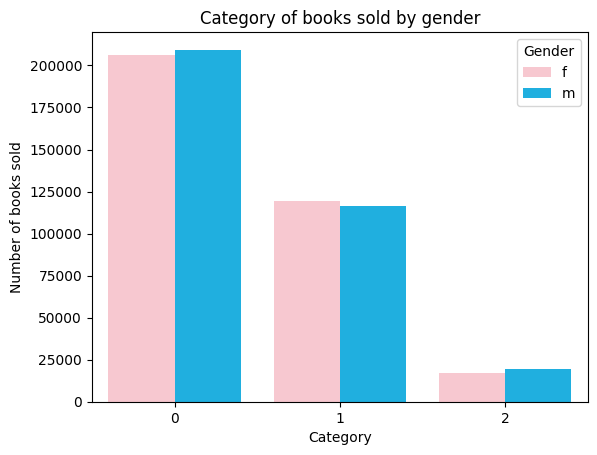

In [62]:
#Visualise the average number of purchases for each customer by category and gender.
sex_categs = tous_dfs.groupby(['sex', 'categ'])['id_prod'].count().reset_index()
sns.barplot(data=sex_categs, x='categ', y='id_prod', hue='sex', palette=['pink', 'deepskyblue'])
plt.title("Category of books sold by gender")
plt.xlabel("Category")
plt.ylabel("Number of books sold")
plt.legend(title='Gender')
plt.show()

In [63]:
#Create a table of contingence
tableau_de_contingence = pd.crosstab(tous_dfs['sex'], tous_dfs['categ'])
tableau_de_contingence

categ       0       1      2
sex                         
f      206103  119307  17283
m      209356  116285  19200

In [64]:
khi2, p, dof, expected = stats.chi2_contingency(tableau_de_contingence)

print("Chi2 statistic =", khi2)
print("P-value =", p)
print("Degree of freedom =",  dof)

Chi2 statistic = 158.25417617304882
P-value = 4.3205822283997063e-35
Degree of freedom = 2


Alternative hypothesis (H1): There is an association between gender and the category of books purchased.

A high chi-square and a very low p-value mean that I should reject the null hypothesis. There is a link between gender and the category of books purchased. However, in reality, the difference between categories purchased is not huge, so this result may not be very useful in marketing.

#### Age and total spend

- H0 = The age of a customer and the total amount of purchases are not linked
- H1 = The age of a customer and the total amount of purchases are linked

In [65]:
# Create a dataframe with age and total spent by each age
age_dépenses = tous_dfs.groupby(['age', 'client_id'])['price'].sum().reset_index().rename(columns={'price':'dépenses_total'})

For the age of the customers
- H0 = Customer ages follow a normal distribution
- H1 = Customer ages do not follow a normal distribution

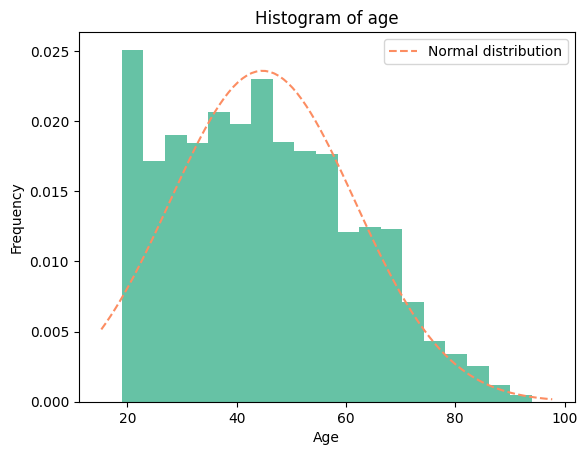

In [66]:
#Create a histogram with the age of the clients

plt.hist(age_dépenses['age'], bins=19, density=True)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of age")

mu, std = norm.fit(age_dépenses['age'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Normal distribution')
plt.legend()
plt.show()



In [67]:
print("Test of Kolmogorov-Smirnov for normality - age")
ks_2samp(age_dépenses['age'],list(np.random.normal(np.mean(age_dépenses['age']), np.std(age_dépenses['age']), 8600)))

Test of Kolmogorov-Smirnov for normality - age


KstestResult(statistic=0.06383720930232559, pvalue=1.1776192942176866e-15, statistic_location=18.996679333369382, statistic_sign=-1)

H1 = Customer ages do not follow a normal distribution.

For the total number of purchases
- H0 = Total customer spending follows a normal distribution
- H1 = Total customer spending does not follow a normal distribution

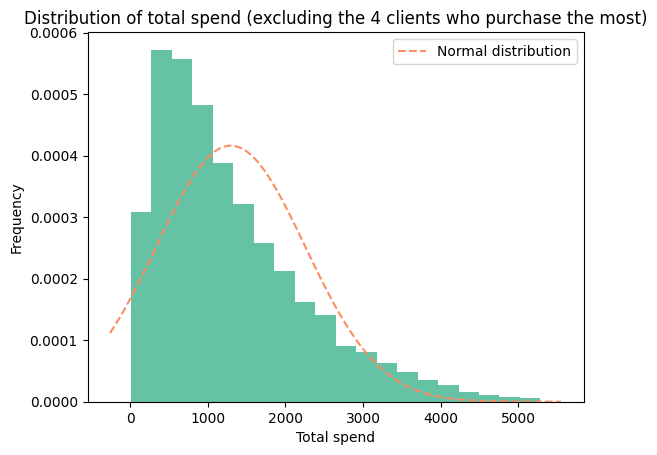

In [68]:
#Removed the clients with the 4 highest levels of spending (probable business customers) to better show the distribution
filter = age_dépenses.loc[age_dépenses['dépenses_total'] <= 100000]

#Create a histogram to visualise spending distribution
plt.hist(filter['dépenses_total'], density=True, bins=20)
plt.xlabel("Total spend")
plt.ylabel("Frequency")
plt.title("Distribution of total spend (excluding the 4 clients who purchase the most)")

mu, std = norm.fit(filter['dépenses_total'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Normal distribution')
plt.legend()
plt.show()

In [69]:
print("Test of Kolmogorov-Smirnov for normality - total spend")
ks_2samp(age_dépenses['dépenses_total'],list(np.random.normal(np.mean(age_dépenses['dépenses_total']), np.std(age_dépenses['dépenses_total']), 1000)))

Test of Kolmogorov-Smirnov for normality - total spend


KstestResult(statistic=0.40906976744186047, pvalue=1.6340701317427362e-135, statistic_location=17.1739574990022, statistic_sign=-1)

H1 = Total customer amounts do not follow a normal distribution

Both variables are not normally distributed. I'm going to use the Spearman Correlation.

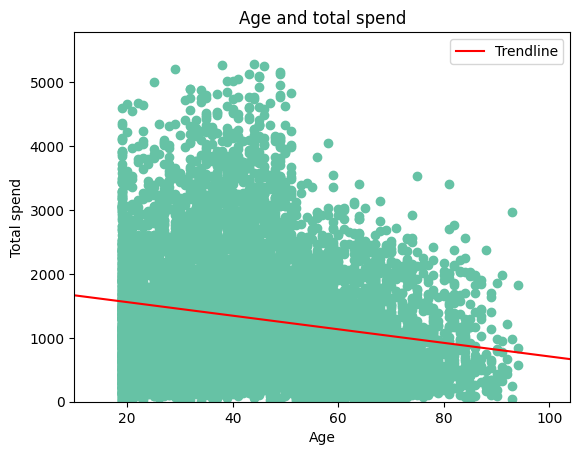

In [70]:
# Create a graph with age and total spend
plt.scatter(filter['age'], filter['dépenses_total'])
plt.xlabel("Age")
plt.ylabel("Total spend")
plt.title("Age and total spend")

#Add a trendline
slope, intercept = np.polyfit(filter['age'], filter['dépenses_total'], 1)
trend_line = slope * x + intercept
plt.xlim(min(filter['age']-9), (max(filter['age']+10)))
plt.ylim(0, max(filter['dépenses_total']+500)) 
plt.plot(x, trend_line, color='red', label='Trendline')


plt.legend()
plt.show()

In [71]:
# Spearman Correlation
spearman_corr, p_value = stats.spearmanr(age_dépenses['age'], age_dépenses['dépenses_total'])
print("Spearman Correlation:", spearman_corr)
print("P-value =", p_value)

Spearman Correlation: -0.18437931323303366
P-value = 1.2374004349920944e-66


A weak and negative link, with such a low p-value. This suggests H1 - there is a relationship between the age of a customer and the total amount of purchases.

#### Age and number of purchases

- Null hypothesis (H0) = The age of a customer and the number of purchases are not linked
- Alternative hypothesis (H1) = The age of a customer and the number of purchases are linked


In [72]:
#Create a dataframe
age_fréquence = tous_dfs.groupby(['age', 'client_id'])['session_id'].nunique().reset_index().rename(columns={'session_id':'fréquence_dachats'})

Number of purchases
- H0 = The number of purchases clients make follows a normal distribution
- H1 = The number of purchases clients make does not follow a normal distribution

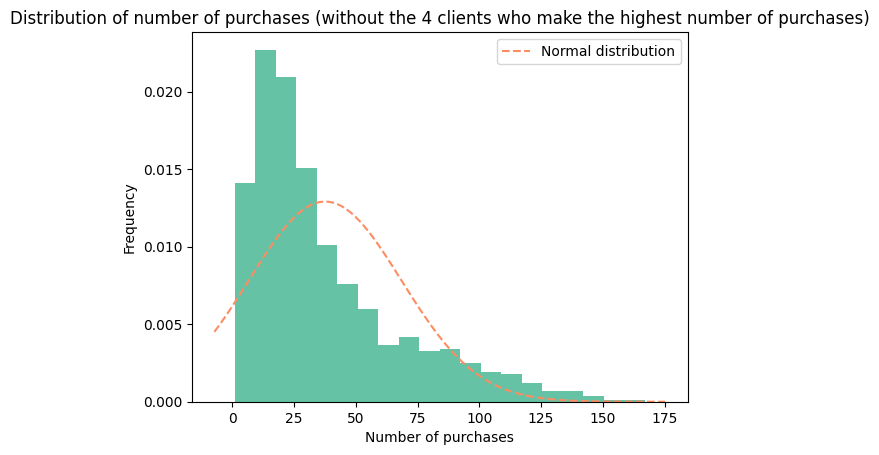

In [73]:
#Removed 4 largest number of purchases (likely professional clients) in order to better show the distribution
filter = age_fréquence.loc[age_fréquence['fréquence_dachats'] <= 2000]

#Create a graph showing distribution of number of purchases
plt.hist(filter['fréquence_dachats'], bins=20, density=True)
plt.xlabel("Number of purchases")
plt.ylabel("Frequency")
plt.title("Distribution of number of purchases (without the 4 clients who make the highest number of purchases)")

mu, std = norm.fit(filter['fréquence_dachats'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Normal distribution')
plt.legend()
plt.show()

In [74]:
print("Test of Kolmogorov-Smirnov for normality - number of purchases")
ks_2samp(age_fréquence['fréquence_dachats'],list(np.random.normal(np.mean(age_fréquence['fréquence_dachats']), np.std(age_fréquence['fréquence_dachats']), 1000)))

Test of Kolmogorov-Smirnov for normality - number of purchases


KstestResult(statistic=0.37467441860465117, pvalue=4.597417743917123e-113, statistic_location=1.8217860474763867, statistic_sign=-1)

H1 = The number of purchases made by clients does not follow a normal distribution.

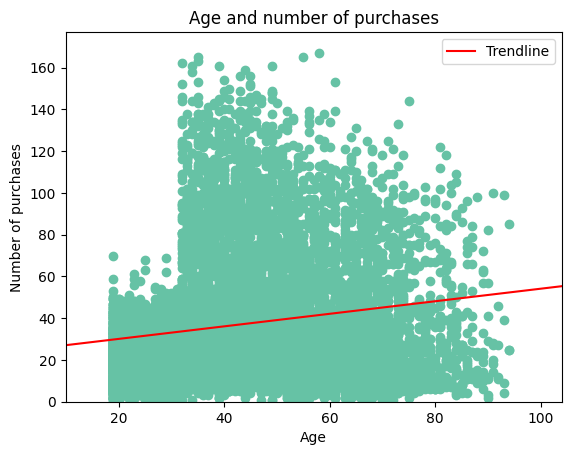

In [75]:
# Graph of age and number of purchases
plt.scatter(filter['age'], filter['fréquence_dachats'])
plt.xlabel("Age")
plt.ylabel("Number of purchases")
plt.title("Age and number of purchases")

#Add a trendline
slope, intercept = np.polyfit(filter['age'], filter['fréquence_dachats'], 1)
trend_line = slope * x + intercept
plt.xlim(min(filter['age']-9), (max(filter['age']+10)))
plt.ylim(0, max(filter['fréquence_dachats']+10)) 
plt.plot(x, trend_line, color='red', label='Trendline')


plt.legend()
plt.show()

In [76]:
# Spearman correlation
spearman_corr, p_value = stats.spearmanr(age_fréquence['age'], age_fréquence['fréquence_dachats'])
print("Spearman Correlation:", spearman_corr)
print("P-value =", p_value)

Spearman Correlation: 0.21176722196238146
P-value = 8.802387924159931e-88


A positive link, with a low p-value. This suggests H1 - there is a link between the age of a customer and the frequency of purchases.

#### Age and average basket size

- Null hypothesis (H0) = The age of a customer and average basket size are not linked
- Hypothesis (H1) = The age of a customer and average basket size are linked

In [77]:
#Create a dataframe with age and basket size
age_panier = tous_dfs.groupby(['age', 'session_id'])['price'].sum().reset_index().rename(columns={'price':'panier_total'})

Average basket size
- H0 = The average basket size follows a normal distribution
- H1 = The average basket size does not follow a normal distribution

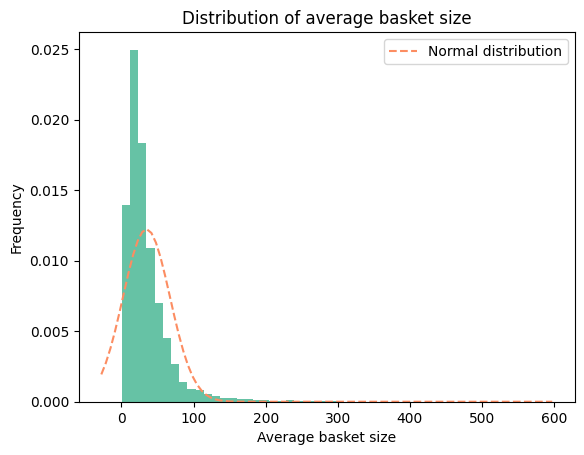

In [78]:
plt.hist(age_panier['panier_total'], bins=50, density=True)
plt.xlabel("Average basket size")
plt.ylabel("Frequency")
plt.title("Distribution of average basket size")

mu, std = norm.fit(age_panier['panier_total'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Normal distribution')
plt.legend()
plt.show()

In [79]:
print("Test of Kolmogorov-Smirnov for normality - average basket size")
ks_2samp(age_panier['panier_total'],list(np.random.normal(np.mean(age_panier['panier_total']), np.std(age_panier['panier_total']), 1000)))

Test of Kolmogorov-Smirnov for normality - average basket size


KstestResult(statistic=0.17713173470716775, pvalue=7.797165467846094e-28, statistic_location=3.2821501882707906, statistic_sign=-1)

Average basket size does not follow a normal distribution

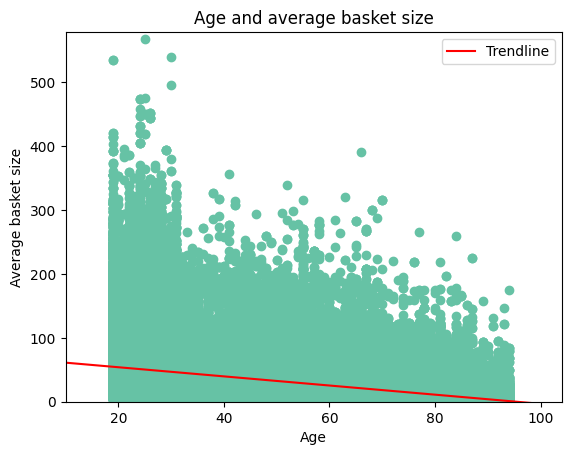

In [80]:
# Age and average basket size graph
plt.scatter(age_panier['age'], age_panier['panier_total'])
plt.xlabel("Age")
plt.ylabel("Average basket size")
plt.title("Age and average basket size")

#Ajouter ligne de tendance
slope, intercept = np.polyfit(age_panier['age'], age_panier['panier_total'], 1)
trend_line = slope * x + intercept
plt.xlim(min(age_panier['age']-9), (max(age_panier['age']+10)))
plt.ylim(0, max(age_panier['panier_total']+10)) 
plt.plot(x, trend_line, color='red', label='Trendline')

plt.legend()
plt.show()

In [81]:
# Spearman correlation
spearman_corr, p_value = stats.spearmanr(age_panier['age'], age_panier['panier_total'])
print("Spearman Correlation:", spearman_corr)
print("P-value =", p_value)

Spearman Correlation: -0.33529100807553497
P-value = 0.0


Hypothesis (H1) = The age of a customer and their average basket size are linked

#### Age of customers and categories of books purchased

- Null hypothesis (H0) = The age of a customer and the category of books purchased are not linked
- Hypothesis (H1) = The age of a customer and the category of books purchased are linked

In [82]:
#Create a new dataframe
age_categ_bar = tous_dfs.groupby(['age', 'categ'])['id_prod'].count().reset_index()

age_categ = tous_dfs[['categ', 'age']]
categ_0 = age_categ[age_categ['categ'] == 0]['age']
categ_1 = age_categ[age_categ['categ'] == 1]['age']
categ_2 = age_categ[age_categ['categ'] == 2]['age']

# Create separate data groups for each book category
categs_livres = {}
for catégorie in age_categ['categ'].unique():
    categs_livres[catégorie] = age_categ[age_categ['categ'] == catégorie]['age']

In [83]:
#Create the contingency table
contingency_table = pd.crosstab(age_categ['age'], age_categ['categ'])
contingency_table

categ     0     1     2
age                    
19     3418  6067  6012
20      909  1798  1784
21     1016  1850  1845
22      974  1676  1728
23     1114  1744  1671
..      ...   ...   ...
90      142   193     1
91      132   178     2
92       77    91     2
93       75   161     2
94       78   123     1

[76 rows x 3 columns]

Category of books purchased
- H0 = The categories of books purchased have equal variances
- H1 = The categories of books purchased do not have equal variances

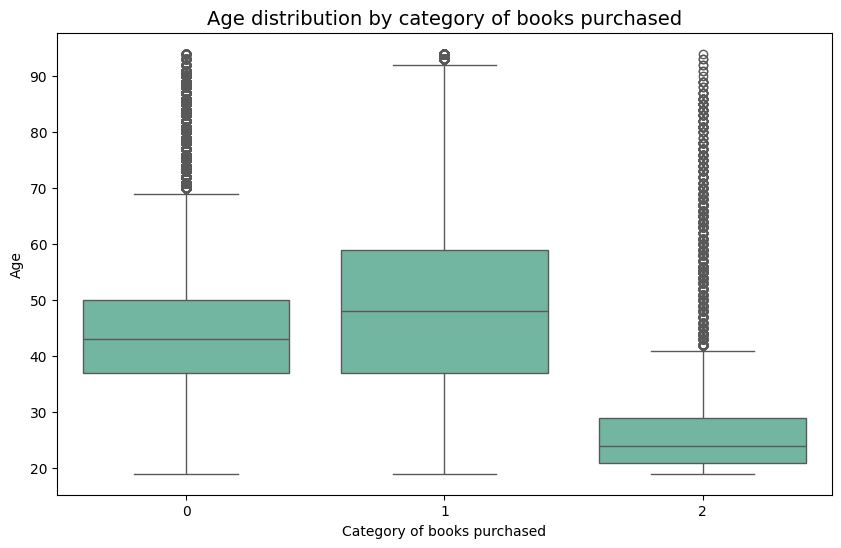

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=age_categ, x='categ', y='age')
plt.title("Age distribution by category of books purchased", size=14)
plt.xlabel('Category of books purchased', size=10)
plt.ylabel('Age', size=10)
plt.xticks()
plt.show()

In [85]:
# Perform Levene's test for equality of variances
levene_test_result = stats.levene(categ_0, categ_1, categ_2)

print("Levene's Test for Equality of Variances:")
print("Statistic:", levene_test_result.statistic)
print("p-value:", levene_test_result.pvalue)

Levene's Test for Equality of Variances:
Statistic: 26975.654952050325
p-value: 0.0


The data variances are not equal. In view of this, and that the ages are not normally distributed, I will use a non-parametric test - Kruskal-Wallis

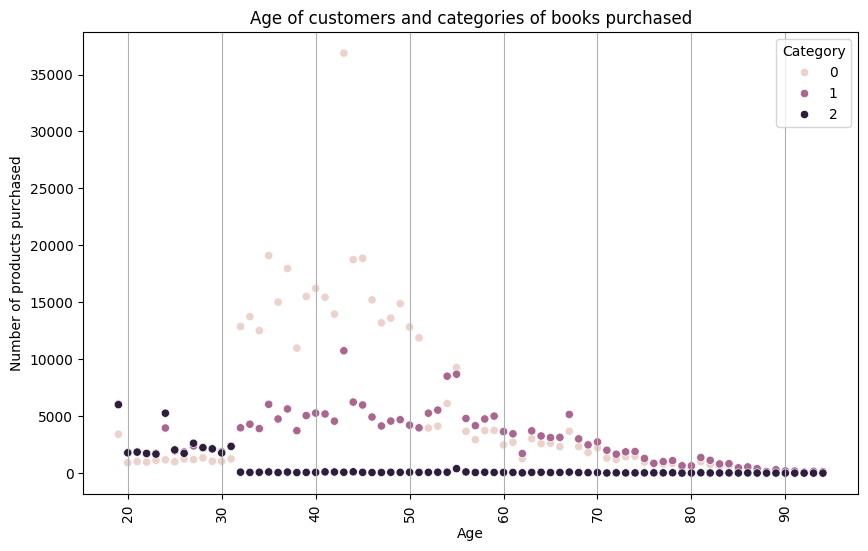

In [86]:
# Créer a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=age_categ_bar, x='age', y='id_prod', hue='categ')
plt.xticks(rotation=90)
plt.title("Age of customers and categories of books purchased")
plt.xlabel("Age")
plt.ylabel("Number of products purchased")
plt.grid(axis='x')
plt.legend(title='Category')

plt.show()

In [87]:
#Kruskall-Wallis
statistic, p_value = stats.kruskal(categ_0, categ_1, categ_2) 
print("Kruskal-Wallis Test")
print("Statistic =", statistic, "p-value =", p_value)

Kruskal-Wallis Test
Statistic = 78458.43837285662 p-value = 0.0


Hypothesis (H1) = The age of a customer and the category of books purchased are linked